# Dynamic Time Warping for Speech Recognition
Chloé Clavel / Matthieu Labeau (original lab by Olivier Cappé)

**TP by: Daniel Deutsch and Kevin Kühl**

In [1]:
import os
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

## Data

The directory ```DATA``` contains three directories :
- ```SIG``` contains 12 repetitions of numbers from 0 to 9 by speaker1 (F e = 8000kHz). SIG_Rep_5_Number_3.wav is the recording corresponding to the fifth repetition of the number “3” . The first four repetitions of each number are represented on Figure 1.
- ```SIG2```, contains 6 repetitions of numbers from 0 to 9 by speaker2
- ```SIG_MIXED``` contains 6 repetitions of the number by speaker1 (SIG_MIXED_Rep_1:6) and then by speaker2 ( SIG_MIXED_Rep_7:12).

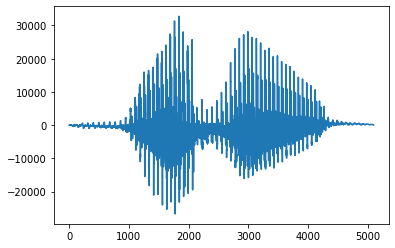

In [2]:
from scipy.io import wavfile

file_path = "./SIG/SIG_Rep_1_Number_0.wav"
sample_rate, wav_data = wavfile.read(file_path)
plt.plot(wav_data)
plt.show()

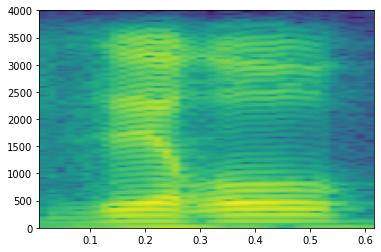

In [3]:
plt.specgram(wav_data, Fs=sample_rate)
plt.show()

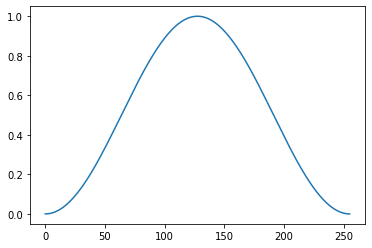

In [4]:
plt.plot(np.hanning(256))

## Speech Feature Extraction

Write a python function ```feature_extraction``` to calculate the cepstral parameterization associated with each pronunciation. With regard to the parameters of the analysis, we will make the following choices: 
- **Parameterization type**: Cepstrum (real number) using linear frequency scale (as opposed to Mel-frequency cepstrum) and computed using FFT (Fast Fourier Transform)
- **Weigthing window**: Hanning

The inputs of the function will be the following:
- **Wav data**: The data extracted from a .wav file
- **Window size**: 256 samples (32 ms)
- **Window shift**: 128 samples
- **Cepstral order**: p = 10


For each signal, the result of the analysis is a sequence of parameters that will be stored in a matrix
according to the following convention:

$$ \quad X = \underbrace{\left[\begin{array}{c} 
 X_1 \\
 X_2 \\
 \vdots \\
 X_{l_X}
\end{array} \right]}_p  $$

Each $X_i$ is a line vector of size $p$. Note that the number of ceptral vectors obtained ($l_X$) depends on the length of the signal, so it is variable. We obtain one matrix of this type per signal.

In [5]:
def feature_extraction(wav_data, window_size, window_shift, cepstral_order):
    #
    # Indication: use the numpy functions np.hanning, np.fft.fft, and np.fft.ifft.
    # Use the attribute .real to take the real part of complex numbers that are output by np.fft.ifft
    # Don't hesitate to look at the numpy documentation to get a better understanding of what the functions do !
    
    # First calculate how many intervals will be analysed
    n_intervals = int((len(wav_data) - window_size)/window_shift)+1
    
    # Initialize cepstral vectors as zeros
    cepstral_vectors = np.zeros((n_intervals,cepstral_order))
    for index in range(n_intervals):
        # Get the current analysed window
        analysed_data = wav_data[index*window_shift:index*window_shift+window_size]
        # Apply fast fourier transform and get absolute value
        # Add small epsilon to avoid taking the logarithm of zero
        windowed_transformed_data = np.abs(np.fft.fft(analysed_data*np.hanning(analysed_data.size))) + 10e-8
        # Apply the logarithm
        log_tranformed_data = np.log(windowed_transformed_data)
        # Compute the inverse fast fourier transform
        inverse_transformed_data = np.fft.ifft(log_tranformed_data)
        # Truncate to match the cepstral order
        cepstral_vectors[index,:] = inverse_transformed_data.real[:cepstral_order]
    
    return cepstral_vectors

In [6]:
# Example !
window_size = 256
window_shift = 128
cepstral_order = 10
cepstral_vectors = feature_extraction(wav_data, window_size, window_shift, cepstral_order)

In [7]:
print("Shape of cepstral matrix:", [len(cepstral_vectors), len(cepstral_vectors[0])])

Shape of cepstral matrix: [38, 10]


## Time Alignment by Dynamic Programming

Write a python function ```time_alignment(x, y, gamma)``` performing time alignment by dynamic programming between two sequences of vectors stored with the convention above. The Euclidean norm between the following vectors and time
constraints will be used:

\begin{matrix}
  \bullet & \rightarrow & \bullet\\
   & \nearrow_{\gamma} & \uparrow\\
  \bullet & & \bullet
\end{matrix}

with a diagonal weighting $\gamma$ that may be chosen different from 1. It is essential to carry out this function in a parameterized way in order to be able to validate it on the mono-dimensional example being studied.
The function will take as **inputs** the two vector sequences $(X_1, \dots, X_{l_X})$ et $(Y_1, \dots, Y_{l_Y})$ stored in the two matrices, as well as the parameter $\gamma$. It will then execute the following operations:
- **Calculation of the similarity matrix**: Given the two vector sequences, calculate the matrix $D (l_X \times l_Y)$ such that $D(i,j) = \|X_i-Y_j\|$.
- **Initialization of the cumulative distance matrix**: Calculate the content of the first row and column of the cumulative distance matrix $C (l_X \times l_Y)$ such that $C(i,j)$ contains the cumulative distance along the minimum cumulative distance path joining the node $(i,j)$ at the initial node $(1,1)$.
- **Calculation of the matrix of cumulative distances**: For $i$ ranging from 2 to $\min(l_X,l_Y)$, calculation of $C(i,i)$ then $C(i+1,i), \dots C(l_X,i)$ and $C(i,i+1), C(i,i+2), \dots C(i,l_Y)$ (you will recall what justifies this way to proceed). To store the predecessor along the optimal path leading to $(i,j)$, you can use a three-dimensional array $B (l_X \times l_Y \times 2)$ since the predecessor is a node of the network defined by its two coordinates (we can alternatively use a "code" representing the three possible predecessors).
- ***Bactracking***: From the node $(l_X,l_Y)$, reconstruction of the optimal path (starting from the end).

Finally, the **output** will be the cumulative distance along the path of least cost  (```distance```) and the alignment path (```M```), in the form of the matrix  $M$  with two columns such that $X_{M(i,1)}$  is the vector mapped to $Y_{M(i,2)}$ (note that the number of lines in this matrix corresponding to the length of the optimal path is variable). The function can also return the matrix of cumulative distances (```C```).

In [8]:
def time_alignment(x, y, gamma):
    # Getting input sizes
    N = len(x)
    M = len(y)
    
    # Building distance matrix
    D = np.zeros((N,M))
    for n in range(N):
        for m in range(M):
            D[n,m] = ((x[n] - y[m])**2).sum()
    
    # Building cumulative distance matrix
    C = np.zeros((N, M))
    C[0, 0] = D[0, 0]
    for n in range(1, N):
        C[n, 0] = C[n-1, 0] + D[n, 0]
    for m in range(1, M):
        C[0, m] = C[0, m-1] + D[0, m]
    for n in range(1, N):
        for m in range(1, M):
            C[n, m] = D[n, m] + min(C[n-1, m], C[n, m-1], gamma*C[n-1, m-1])
    
    # Finding optimal path (starting from the end)
    n = N - 1
    m = M - 1
    P = [(n, m)]
    while n > 0 or m > 0:
        # Reached one of the edges
        if n == 0:
            prev = (0, m - 1)
        elif m == 0:
            prev = (n - 1, 0)
        # Else find the minimum cumulative distance
        else:
            dist = min(gamma*C[n-1, m-1], C[n-1, m], C[n, m-1])
            if dist == gamma*C[n-1, m-1]:
                prev = (n-1, m-1)
            elif dist == C[n-1, m]:
                prev = (n-1, m)
            else:
                prev = (n, m-1)
        # Store node (predecessor as we are going backwards)
        P.append(prev)
        (n, m) = prev
    # Invert to begin to end order
    P.reverse()
    
    # Getting distance for optimal path
    distance = C[-1,-1]
    return C, np.array(P), distance, D

In [9]:
# Example of time alignment
file_path_1 = "./SIG/SIG_Rep_1_Number_0.wav"
sample_rate_1, wav_data_1 = wavfile.read(file_path_1)
file_path_2 = "./SIG/SIG_Rep_2_Number_0.wav"
sample_rate_2, wav_data_2 = wavfile.read(file_path_2)
cepstral_vectors_1 = feature_extraction(
wav_data_1, window_size, window_shift, cepstral_order)
cepstral_vectors_2 = feature_extraction(
wav_data_2, window_size, window_shift, cepstral_order)
np.set_printoptions(precision=4)

C, M, distance, D = time_alignment(cepstral_vectors_1, cepstral_vectors_2, gamma=2)

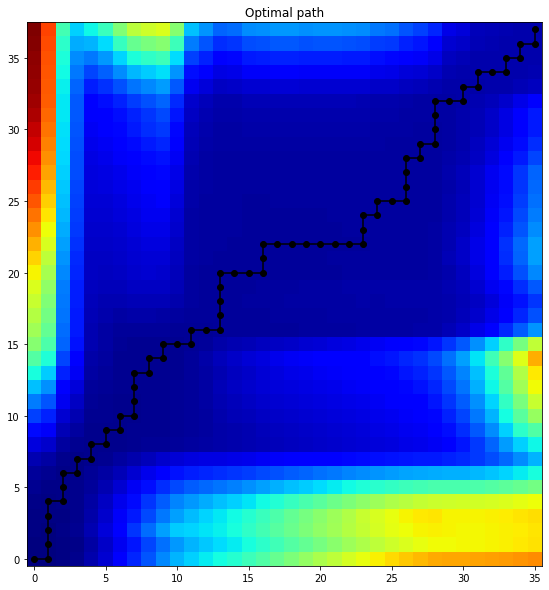

Cost of the optimal path: 12.790725439475223


In [10]:
# Example of visualization of the optimal path
plt.rcParams["figure.figsize"] = (10,10)
M = np.array(M)
plt.imshow(C, cmap='jet', origin='lower')
plt.title("Optimal path")
plt.plot(M[:,1], M[:,0], marker='o', color='black')
plt.show()
print("Cost of the optimal path:", distance)

## Applications to Speech Data

First, working on the data from ```SIG```, you will align a reference sequence (for example, the one corresponding to the first repetition of the first word) with all the others. If we try to find, among all numbers of a given repetition (from 1 to 12), which is the same one as the reference, by looking at the closest in terms of distance (of the path of least cost):
1. Are the performances satisfactory ?
2. What is the influence of the γ choice (weighting of the diagonal path) on the alignment paths (in order to answer, examine characteristic cases and try to judge the relevance of the alignment paths by visualizing them) ? Does this parameter have a significant influence on the obtained distance?
3. What implicit hypothesis is made when using the Euclidean distance to measure the proximity of ceptral vectors? Does this hypothesis seem acceptable to you in view of the differences between aligned sequences corresponding to different repetitions of the same word? Propose (it is not necessary to implement it!) a method to estimate from the aligned data an appropriate weighting for the comparison of ceptral vectors. Do you think this weighting could improve discrimination performance?

In [11]:
# Let's take all the repetitions and compare them with the repetitions of number 7
# We expect to have lowest distances to other repetitions from number 7
repetitions = []
for number in range(10):
    for repetition in range(1,13):
        repetitions.append(f"./SIG/SIG_Rep_{repetition}_Number_{number}.wav")

In [12]:
reference = "./SIG/SIG_Rep_3_Number_7.wav"
ref_sr, ref_wav_data = wavfile.read(reference)
ref_cepstral_vectors = feature_extraction(ref_wav_data, window_size, window_shift, cepstral_order)
dist = []
for compared in repetitions:
    comp_sr, comp_wav_data = wavfile.read(compared)
    comp_cepstral_vector = feature_extraction(comp_wav_data, window_size, window_shift, cepstral_order)
    C, M, distance, D = time_alignment(ref_cepstral_vectors, comp_cepstral_vector, gamma=2)
    dist.append(distance)
    
# There are a total of 12 repetitions
# Therefore, if we order the repetitions by distance and select the first 12 we expect to see only
# repetitions of number 7
# Also we expect the minimum distance to be from the reference to itself
sort_indexes = np.argsort(dist)[:12]
for j, index in enumerate(sort_indexes):
    print(f"{j+1}) {repetitions[index]}") 

1) ./SIG/SIG_Rep_3_Number_7.wav
2) ./SIG/SIG_Rep_4_Number_7.wav
3) ./SIG/SIG_Rep_5_Number_7.wav
4) ./SIG/SIG_Rep_7_Number_7.wav
5) ./SIG/SIG_Rep_2_Number_7.wav
6) ./SIG/SIG_Rep_6_Number_7.wav
7) ./SIG/SIG_Rep_10_Number_7.wav
8) ./SIG/SIG_Rep_1_Number_7.wav
9) ./SIG/SIG_Rep_8_Number_7.wav
10) ./SIG/SIG_Rep_8_Number_5.wav
11) ./SIG/SIG_Rep_11_Number_7.wav
12) ./SIG/SIG_Rep_7_Number_5.wav


Performance is satisfactory but it depends on the data you choose as reference. In the performed example above, on the top 12 closest sequencies, 10 correspond to repetitions of the number 7 (out of 12 expected). This is a reasonably good result.

In [13]:
# Let's change the gamma to see if it impacts directly on the performance
reference = "./SIG/SIG_Rep_3_Number_7.wav"
ref_sr, ref_wav_data = wavfile.read(reference)
ref_cepstral_vectors = feature_extraction(ref_wav_data, window_size, window_shift, cepstral_order)
dist = []
for compared in repetitions:
    comp_sr, comp_wav_data = wavfile.read(compared)
    comp_cepstral_vector = feature_extraction(comp_wav_data, window_size, window_shift, cepstral_order)
    C, M, distance, D = time_alignment(ref_cepstral_vectors, comp_cepstral_vector, gamma=0.1)
    dist.append(distance)
    
# There are a total of 12 repetitions
# Therefore, if we order the repetitions by distance and select the first 12 we expect to see only
# repetitions of number 7
# Also we expect the minimum distance to be from the reference to itself
sort_indexes = np.argsort(dist)[:12]
for j, index in enumerate(sort_indexes):
    print(f"{j+1}) {repetitions[index]}") 

1) ./SIG/SIG_Rep_3_Number_7.wav
2) ./SIG/SIG_Rep_7_Number_7.wav
3) ./SIG/SIG_Rep_6_Number_7.wav
4) ./SIG/SIG_Rep_5_Number_7.wav
5) ./SIG/SIG_Rep_1_Number_9.wav
6) ./SIG/SIG_Rep_4_Number_6.wav
7) ./SIG/SIG_Rep_6_Number_8.wav
8) ./SIG/SIG_Rep_2_Number_4.wav
9) ./SIG/SIG_Rep_4_Number_7.wav
10) ./SIG/SIG_Rep_6_Number_4.wav
11) ./SIG/SIG_Rep_8_Number_8.wav
12) ./SIG/SIG_Rep_11_Number_9.wav


Using a low value for gamma (lower than 1) implies in paths that will favorise the diagonal. Such a low value of gamma would imply that both audio sequences have a linear time deformation. If we increase the value of gamma, we favourise the consideration of non linear deformation. In the case above, a very small value of gamma (0.1) caused the performance to drop considerably, which may indicate that time deformation between the sequences is not linear.

When using the Euclidean distance, we penalize a lot outliers points. This has a direct impact on samples where the speakers have different speech rithms. As this is as very common situtation in human speeching (speaking with different speeds), the most adequate way to compare cepstral vectors without penalizing too much this natural phenomenon is to consider a norm such as the L1, instead of L2.

## Evaluation of Speech Recognition

The goal of this part is to implement different cross-validation strategies in order to evaluate how well our method can be used for speech recognition, especially when we generalize to more than one speaker. 
We will separate the available signals into a *training* and *testing* set, and label all the test signals by finding the signal in the training set they are the closest to (in terms of cost of the optimal path given by ```time_alignement```. We will then rotate the training/testing sets to perform cross-validation. 
To do so, write a function ```evaluation_recognition```. For example, you can use the following formalism : 

```[confusion, accuracy, D] = evaluation_recognition(vectors, gamma, protocol)```

- ```vectors``` contains all the cepstral vectors for the signals in the database. It can be under the form of a list of matrices, being the outputs of ```feature_extraction``` for all signals. If $N$ if the number of repetetitions, ```vectors``` contains $10N$ matrices.
- ```gamma``` is the parameter $\gamma$ of the alignment.
- ```protocol``` is an integer value between 1 and 3 indicating the protocol to be used: each protocol corresponds to a particular way of dividing signals into training and testing sets. 


- ```confusion``` is the confusion matrix of size $10 \times 10$.
- ```accuracy``` is the recognition rate.
- ```D``` is the distance matrix between each of the elements of the database of size $10N \times 10N$, where $N$ is the number of repetitions. Note that only parts of ```D``` will be used, depending on the protocol choosed. 

The three proposed evaluation protocols are:
- **Protocol 1**: The database is randomly divided in three subsets. Two of these subsets (2/3 of repetitions) are used for the training set and the remaining subset (1/3 of repetitions) is used for the test set. The procedure is repeated by rotating the test and training sets.
- **Protocol 2**: A database containing only one pronunciation of each number is used as a training database. The remaining repetitions are used for the test set. The procedure is repeated by rotating the test and training sets. This protocol aims at evaluating the generalization capabilities of the recognition system. 
- **Protocol 3**: The first half of the database of ```SIG_MIXED``` is used as a training database and the second half as the test database. The procedure is repeated by inversing the role of the two sets. This protocol aims at evaluating the generalization capabilities on a database containing data from the two speakers. Careful: since the goal here is to understand if you can use examples from one person to recognize numbers pronounced by a different person, you have to not shuffle the examples !

In [14]:
cepstral_vectors = []
labels = []
for number in range(10):
    for repetition in range(1,13):
        sample_rate, wav_data = wavfile.read(f"./SIG/SIG_Rep_{repetition}_Number_{number}.wav")
        cepstral_vectors.append(feature_extraction(wav_data, window_size, window_shift, cepstral_order))
        labels.append(number)
cepstral_vectors = np.array(cepstral_vectors, dtype=object)
labels = np.array(labels)

In [15]:
def evaluation_recognition(vectors,gamma,protocol):
    if protocol == 1:
        randomized_indexes = np.arange(vectors.shape[0])
        np.random.shuffle(randomized_indexes)
        confusion_matrices = []
        accuracies = []
        all_distances = []
        for rotation in range(3):
            indexes_test = [randomized_indexes[rotation::3]]
            indexes_train = [i for i in randomized_indexes if i not in randomized_indexes[rotation::3]]
            X_test = vectors[tuple(indexes_test)]
            X_train = vectors[indexes_train]
            Y_test = labels[tuple(indexes_test)]
            Y_train = labels[indexes_train]
            distances = np.zeros((Y_test.size,Y_train.size))
            for index_test, cep_vector_test in enumerate(X_test):
                for index_train, cep_vector_train in enumerate(X_train):
                    C, M, distance, D = time_alignment(cep_vector_test, cep_vector_train, gamma=2)
                    distances[index_test,index_train] = distance
            predictions = Y_train[np.argmin(distances,axis=1)]
            conf_matrix = confusion_matrix(Y_test,predictions)
            accuracy = accuracy_score(Y_test, predictions)
            confusion_matrices.append(conf_matrix)
            accuracies.append(accuracy)
            all_distances.append(distances)
        return confusion_matrices, accuracies, all_distances
    elif protocol == 2:
        confusion_matrices = []
        accuracies = []
        all_distances = []
        for rotation in range(12):
            indexes_train = np.arange(vectors.shape[0])[rotation::12]
            indexes_test = [i for i in np.arange(vectors.shape[0]) if i not in indexes_train]
            X_test = vectors[indexes_test]
            X_train = vectors[indexes_train]
            Y_test = labels[indexes_test]
            Y_train = labels[indexes_train]
            distances = np.zeros((Y_test.size,Y_train.size))
            for index_test, cep_vector_test in enumerate(X_test):
                for index_train, cep_vector_train in enumerate(X_train):
                    C, M, distance, D = time_alignment(cep_vector_test, cep_vector_train, gamma=2)
                    distances[index_test,index_train] = distance
            predictions = Y_train[np.argmin(distances,axis=1)]
            conf_matrix = confusion_matrix(Y_test,predictions)
            accuracy = accuracy_score(Y_test, predictions)
            confusion_matrices.append(conf_matrix)
            accuracies.append(accuracy)
            all_distances.append(distances)
        return confusion_matrices, accuracies, all_distances
    elif protocol == 3:
        confusion_matrices = []
        accuracies = []
        all_distances = []
        for rotation in range(2):
            indexes_test = np.arange(120)[(rotation)*60:(rotation+1)*60]
            indexes_train = [i for i in np.arange(120) if i not in indexes_test]
            X_test = vectors[indexes_test]
            X_train = vectors[indexes_train]
            Y_test = labels[indexes_test]
            Y_train = labels[indexes_train]
            distances = np.zeros((Y_test.size,Y_train.size))
            for index_test, cep_vector_test in enumerate(X_test):
                for index_train, cep_vector_train in enumerate(X_train):
                    C, M, distance, D = time_alignment(cep_vector_test, cep_vector_train, gamma=2)
                    distances[index_test,index_train] = distance
            predictions = Y_train[np.argmin(distances,axis=1)]
            conf_matrix = confusion_matrix(Y_test,predictions)
            accuracy = accuracy_score(Y_test, predictions)
            confusion_matrices.append(conf_matrix)
            accuracies.append(accuracy)
            all_distances.append(distances)
        return confusion_matrices, accuracies, all_distances

In [16]:
# For protocol 1
conf_matrices, accuracies, distances = evaluation_recognition(cepstral_vectors,2,1)

In [17]:
print("Protocol 1 - Speaker 1")
print("For gamma = 2")
print(f"Average accuracy: {np.mean(accuracies)}")
for i in range(3):
    print(f"Rotation {i}")
    print("Confusion matrix")
    print(conf_matrices[i])
    print(f"Accuracy: {accuracies[i]}")
    print()

Protocol 1 - Speaker 1
For gamma = 2
Average accuracy: 0.975
Rotation 0
Confusion matrix
[[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 6 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 4]]
Accuracy: 1.0

Rotation 1
Confusion matrix
[[2 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 6 0 0 0]
 [0 0 0 0 0 1 0 3 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 4]]
Accuracy: 0.975

Rotation 2
Confusion matrix
[[3 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 5 0 1 0 0]
 [0 0 0 0 0 0 4 0 0 0]
 [0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 1 0 3 0]
 [0 0 0 0 0 0 0 0 0 4]]
Accuracy: 0.95



In [18]:
# Experiencing with other gamma values
accuracies = []
for gamma in range(5):
    accuracies.append(np.mean(evaluation_recognition(cepstral_vectors,gamma,1)[1]))

In [19]:
for index, acc in enumerate(accuracies):
    print(f"Gamma: {index} - Accuracy: {acc}")

Gamma: 0 - Accuracy: 0.9833333333333334
Gamma: 1 - Accuracy: 0.9833333333333334
Gamma: 2 - Accuracy: 0.9583333333333334
Gamma: 3 - Accuracy: 0.9833333333333334
Gamma: 4 - Accuracy: 0.9833333333333334


In [21]:
# For speaker 2
cepstral_vectors = []
labels = []
for number in range(10):
    for repetition in range(1,7):
        sample_rate, wav_data = wavfile.read(f"./SIG2/SIG2_Rep_{repetition}_Number_{number}.wav")
        cepstral_vectors.append(feature_extraction(wav_data, window_size, window_shift, cepstral_order))
        labels.append(number)
cepstral_vectors = np.array(cepstral_vectors, dtype=object)
labels = np.array(labels)
conf_matrices, accuracies, distances = evaluation_recognition(cepstral_vectors,2,1)
print("Protocol 1 - Speaker 2")
print("For gamma = 2")
print(f"Average accuracy: {np.mean(accuracies)}")
for i in range(3):
    print(f"Rotation {i}")
    print("Confusion matrix")
    print(conf_matrices[i])
    print(f"Accuracy: {accuracies[i]}")
    print()

Protocol 1 - Speaker 2
For gamma = 2
Average accuracy: 0.9666666666666667
Rotation 0
Confusion matrix
[[2 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 3]]
Accuracy: 0.95

Rotation 1
Confusion matrix
[[2 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 3]]
Accuracy: 1.0

Rotation 2
Confusion matrix
[[2 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0]
 [0 0 0 4 0 0 0 0]
 [0 0 0 0 2 0 0 0]
 [0 0 0 0 0 2 0 0]
 [0 1 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 1]]
Accuracy: 0.95



In [22]:
# For protocol 2
cepstral_vectors = []
labels = []
for number in range(10):
    for repetition in range(1,13):
        sample_rate, wav_data = wavfile.read(f"./SIG/SIG_Rep_{repetition}_Number_{number}.wav")
        cepstral_vectors.append(feature_extraction(wav_data, window_size, window_shift, cepstral_order))
        labels.append(number)
cepstral_vectors = np.array(cepstral_vectors, dtype=object)
labels = np.array(labels)
conf_matrices, accuracies, distances = evaluation_recognition(cepstral_vectors,2,2)

In [23]:
print("Protocol 2 - Speaker 1")
print("For gamma = 2")
print(f"Average accuracy: {np.mean(accuracies)}")
for i in range(12):
    print(f"Rotation {i}")
    print("Confusion matrix")
    print(conf_matrices[i])
    print(f"Accuracy: {accuracies[i]}")
    print()

Protocol 2 - Speaker 1
For gamma = 2
Average accuracy: 0.8719696969696971
Rotation 0
Confusion matrix
[[11  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  1]
 [ 0  0  4  0  0  0  0  0  0  7]
 [ 0  0  0 10  0  0  0  0  0  1]
 [ 0  0  0  0  6  0  0  5  0  0]
 [ 0  0  0  0  0 10  0  1  0  0]
 [ 0  0  0  0  0  0 11  0  0  0]
 [ 0  0  0  0  0  2  0  9  0  0]
 [ 0  0  0  0  0  0  0  0 11  0]
 [ 0  0  0  0  0  0  0  0  0 11]]
Accuracy: 0.8454545454545455

Rotation 1
Confusion matrix
[[11  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  1  0  0  0  0]
 [ 4  0  5  0  0  0  0  0  0  2]
 [ 1  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0  4  5  0  1  0  1]
 [ 0  0  0  0  0 11  0  0  0  0]
 [ 0  0  0  0  0  0 11  0  0  0]
 [ 0  0  0  0  0  1  0 10  0  0]
 [ 1  0  0  0  0  0  1  0  9  0]
 [ 0  0  0  0  0  0  0  0  0 11]]
Accuracy: 0.8363636363636363

Rotation 2
Confusion matrix
[[11  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  1  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  7]
 [ 0  0  0 11  0  0  

In [24]:
# Experiencing with other gamma values
accuracies = []
for gamma in range(5):
    accuracies.append(np.mean(evaluation_recognition(cepstral_vectors,gamma,2)[1]))

In [25]:
for index, acc in enumerate(accuracies):
    print(f"Gamma: {index} - Accuracy: {acc}")

Gamma: 0 - Accuracy: 0.8719696969696971
Gamma: 1 - Accuracy: 0.8719696969696971
Gamma: 2 - Accuracy: 0.8719696969696971
Gamma: 3 - Accuracy: 0.8719696969696971
Gamma: 4 - Accuracy: 0.8719696969696971


In [26]:
# For speaker 2
cepstral_vectors = []
labels = []
for number in range(10):
    for repetition in range(1,7):
        sample_rate, wav_data = wavfile.read(f"./SIG2/SIG2_Rep_{repetition}_Number_{number}.wav")
        cepstral_vectors.append(feature_extraction(wav_data, window_size, window_shift, cepstral_order))
        labels.append(number)
cepstral_vectors = np.array(cepstral_vectors, dtype=object)
labels = np.array(labels)
conf_matrices, accuracies, distances = evaluation_recognition(cepstral_vectors,2,2)
print("Protocol 2 - Speaker 2")
print("For gamma = 2")
print(f"Average accuracy: {np.mean(accuracies)}")
for i in range(3):
    print(f"Rotation {i}")
    print("Confusion matrix")
    print(conf_matrices[i])
    print(f"Accuracy: {accuracies[i]}")
    print()

Protocol 2 - Speaker 2
For gamma = 2
Average accuracy: 0.42424242424242425
Rotation 0
Confusion matrix
[[5 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 2 0 0 0 0 0]
 [1 0 3 0 1 0 0 0 0 0]
 [0 0 4 0 2 0 0 0 0 0]
 [0 0 3 0 2 0 0 0 0 0]
 [0 0 0 0 4 0 1 0 1 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 1 0 4 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 1 0 4 0 0 0 1 0]]
Accuracy: 0.36363636363636365

Rotation 1
Confusion matrix
[[5 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 5 0 0 0 0 0]
 [1 0 4 0 0 0 0 0 0 0]
 [3 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [1 0 2 0 3 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 4 0 0 0 2 0]
 [0 0 0 0 0 0 1 0 4 0]
 [4 0 2 0 0 0 0 0 0 0]]
Accuracy: 0.41818181818181815

Rotation 2
Confusion matrix
[[5 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 1 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [2 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 5 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 2 0 3 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 4 0]
 [1 0 4 0 1 0 0 0 0 0]]
Accuracy: 0.43636363636363634



In [27]:
# For protocol 3
cepstral_vectors = []
labels = []
for number in range(10):
    for repetition in range(1,13):
        sample_rate, wav_data = wavfile.read(f"./SIGMIX/SIGMIX_Rep_{repetition}_Number_{number}.wav")
        cepstral_vectors.append(feature_extraction(wav_data, window_size, window_shift, cepstral_order))
        labels.append(number)
cepstral_vectors = np.array(cepstral_vectors, dtype=object)
labels = np.array(labels)

In [28]:
conf_matrices, accuracies, distances = evaluation_recognition(cepstral_vectors,2,3)

In [29]:
print("Protocol 3 - Mixed Set")
print("For gamma = 2")
print(f"Average accuracy: {np.mean(accuracies)}")
for i in range(2):
    print(f"Rotation {i}")
    print("Confusion matrix")
    print(conf_matrices[i])
    print(f"Accuracy: {accuracies[i]}")
    print()

Protocol 3 - Mixed Set
For gamma = 2
Average accuracy: 0.0
Rotation 0
Confusion matrix
[[0 0 0 0 0 0 2 2 8]
 [0 0 0 0 0 0 0 4 8]
 [0 0 0 0 0 0 3 5 4]
 [0 0 0 0 0 1 5 2 4]
 [0 0 0 0 0 0 0 9 3]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
Accuracy: 0.0

Rotation 1
Confusion matrix
[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [7 2 0 3 0 0 0 0 0]
 [0 9 1 2 0 0 0 0 0]
 [1 3 0 8 0 0 0 0 0]
 [0 4 0 8 0 0 0 0 0]
 [3 9 0 0 0 0 0 0 0]]
Accuracy: 0.0



In [30]:
# Experiencing with other gamma values
accuracies = []
for gamma in [0.5,1,1.5,2,2.5]:
    accuracies.append(np.mean(evaluation_recognition(cepstral_vectors,gamma,3)[1]))

In [31]:
for index, acc in enumerate(accuracies):
    print(f"Gamma: {index} - Accuracy: {acc}")

Gamma: 0 - Accuracy: 0.0
Gamma: 1 - Accuracy: 0.0
Gamma: 2 - Accuracy: 0.0
Gamma: 3 - Accuracy: 0.0
Gamma: 4 - Accuracy: 0.0


Questions: 
- Evaluate the speech recognition performance with protocol 1 on the data ```SIG```, and then on the data ```SIG2```. What are the confusions ? What value of $\gamma$ parameter offers the best results ?
- Evaluate the generalization capabilities using protocol 2 on the data ```SIG```, and then on the data ```SIG2```. What do you notice?
- Evaluate the generalization capabilities to other speakers using protocol 3 on ```SIG_MIXED```. Explain the results.
- What are the limitations of dynamic time warping approaches for speech recognition that you have identified during this lab ? Propose possible solutions to these problems.

1) Protocol 1 indicates a good performance for both speakers 1 and 2 using the proposed train/test split. The accuracy doesn't change a lot with respect to gamma, but usually higher values of gamma tend to perform better.

2) Protocol 2 offers a lower accuracy than the one obtained in protocol 1. This was expected as we reduced the training set to only one repetition of a given number. Also here we observe the trend that higher values of gamma offer an improvement in accuracy.

3) The last protocol didn't work well with our examples. The accuracy was calculated the same way as in protocol 1 and 2, only changing the way train and test sets were determined. The performance was very poor, indicating bad generalization capabilities

4) On the limitations, the one that was most noticeable is the time consumption. This is due to the number of comparisons needed in each execution. Protocol 1 offered a good perfomance, but needs to compare a wide number of series. Also, another limitation is on the generalization, as some changes would have to be implemented in order to better generalize the recognition.